In [62]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/df_indi_works_occupations.csv", index_col=0)


1810

In [ ]:


regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions['region_name'][regions['region_name']=='Slav world'] = 'East Slavic'

regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]

df["century"] = df["decade"].round(-2)
df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
#df = df[df['decade']>=1800]


df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})

# about 6% of women compared to men
df_m = df_m[df_m['decade']<=1880]

# knots
num_knots = 5
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(1000, random_state=42)
sample = sample.drop('occupation', axis=1).drop_duplicates()
sample = sample.sample(1000, random_state=42)

In [8]:
# SECOND MODEL
priors_base_model = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample[['decade','region_name', 'y']], 
    family='bernoulli', 
    priors=priors_base_model)

base_model_fitted = base_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently


Modeling the probability that y==1
Compiling...
2024-03-07 16:48:49.536040: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:03.177906
Sampling...
sample: 100%|██████████| 2000/2000 [00:22<00:00, 89.72it/s, 31 st

In [ ]:
# get the real number of indiviudals

In [20]:
list(set(df.region_name))

['France',
 'Italy',
 'Low countries',
 'Nordic countries',
 'Eastern Europe',
 'United Kingdom']

[1860, 1830, 1870, 1840, 1810, 1880, 1850, 1820]

In [53]:
region ='France'
new_data = {}

data = df[df["region_name"] == region]
new_data["decade"] = data["decade"].values 
new_data["region_name"] = [region] * len(data["decade"].values)
new_data = pd.DataFrame(new_data)
base_model.predict(base_model_fitted, data=new_data)

NameError: name 'obs_data' is not defined

NameError: name 'plot_knots' is not defined

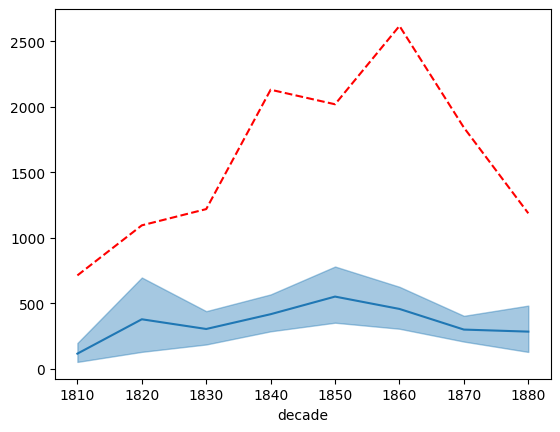

In [41]:
plot_estimations(sample, sample, base_model_fitted, base_model, region = 'France')

In [39]:
def plot_estimations(data, obs_data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    obs_data = obs_data[obs_data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=region)
    
    df[df["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades


In [ ]:


models['base-model'] = base_model_fitted
az.waic(models['base-model'])



In [ ]:

models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))}

occupation_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + occupation + (1|region_name)', 
    sample[['decade','region_name', 'occupation', 'y']], 
    family='bernoulli', 
    priors=priors)

occupation_model_fitted = occupation_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently

models['occupation-model'] = occupation_model_fitted
az.waic(models['occupation-model'])

forest_plot = az.plot_forest(
    data=occupation_model_fitted, 
    figsize=(6, 4), 
    var_names=["occupation"], 
    r_hat=True, 
    combined=True, 
    textsize=8,
    ess=True
)

fig = forest_plot[0].get_figure()
fig.set_size_inches(8, 4)  # Adjust size as needed
fig.tight_layout()

fig.savefig('results/occupation/forest_plot.png')




# Comparison
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True)

waic_compare.to_csv('results/occupation/model_comparison.csv')

compare_plot = az.plot_compare(waic_compare, insample_dev=True)
fig = compare_plot.get_figure()
fig.set_size_inches(8, 4)  # Adjust size as needed
fig.tight_layout()

fig.savefig('results/occupation/compare_plot.png')


list_summaries = []

for key, item in models.items():
    res = az.summary(item)
    res['model'] = key
    list_summaries.append(res)



from datetime import datetime
df_summaries = pd.concat([x for x in list_summaries])
# Add a column with the current time
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_summaries['time'] = current_time
df_summaries.to_csv('results/occupation/model_results.csv')